# Ball and stick 3: Extensible network of cells

This is the third part of a tutorial series where we build a multicompartment cell and evolve it into a network of cells running on a parallel machine. In this part, we take the functionality of the ring network we constructed in the previous page and encapsulate it into various classes so that the network is more extensible. We also begin parameterizing the model so that particular values are not hard-coded, but remain variable so that the model is flexible.

## Loading libraries

As before, we will begin by loading relevant NEURON libraries:

In [1]:
from neuron import h, gui
from neuron.units import ms, mV

h.load_file("stdrun.hoc")

1.0

## Generic Cell class

In the last tutorial, we created a generic `Cell` class (actually, two versions) but we can expand this to make it more powerful. For example, let's make each Cell record its spike times, some membrane potential timeseries, and keep track of NetCons.

In [2]:
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)

        # everything below here in this method is NEW
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)

        self._ncs = []

        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)

    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z

    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

Since the `BallAndStick` has a simple geometry, we could modify it to assume that all inputs go into a single location; we will call it the `.syn`.

In [3]:
class BallAndStick(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.dend = h.Section(name="dend", cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert("pas")
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65  # Leak reversal potential mV

        # NEW: the synapse
        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms

Due to the nature of `h.ExpSyn` decay, there is mathematically no difference between having two ExpSyn objects at the same point or one synapse where multiple inputs add linearly, so it suffices to have just the one as long as we're happy with all inputs going into `dend(0.5)`.

## Make a Ring class

Encapsulating code into discrete objects is not only conceptually useful for code management, but as we know with cell objects, it lets us make several instances of the object for use in a network. Thinking ahead, we may very well need several networks – each network configured differently. This allows scripting of several simulations <i>en masse</i>, either in a for loop that sequentially processes the networks, or it can be used with NEURON's <a href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/parcon.html#ParallelContext.subworlds">subworlds</a> architecture in a parallel context.

In [4]:
class Ring:
    """A network of *N* ball-and-stick cells where cell n makes an
    excitatory synapse onto cell n + 1 and the last, Nth cell in the
    network projects to the first cell.
    """

    def __init__(
        self, N=5, stim_w=0.04, stim_t=9, stim_delay=1, syn_w=0.01, syn_delay=5, r=50
    ):
        """
        :param N: Number of cells.
        :param stim_w: Weight of the stimulus
        :param stim_t: time of the stimulus (in ms)
        :param stim_delay: delay of the stimulus (in ms)
        :param syn_w: Synaptic weight
        :param syn_delay: Delay of the synapse
        :param r: radius of the network
        """
        self._syn_w = syn_w
        self._syn_delay = syn_delay
        self._create_cells(N, r)
        self._connect_cells()
        # add stimulus
        self._netstim = h.NetStim()
        self._netstim.number = 1
        self._netstim.start = stim_t
        self._nc = h.NetCon(self._netstim, self.cells[0].syn)
        self._nc.delay = stim_delay
        self._nc.weight[0] = stim_w

    def _create_cells(self, N, r):
        self.cells = []
        for i in range(N):
            theta = i * 2 * h.PI / N
            self.cells.append(
                BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta)
            )

    def _connect_cells(self):
        for source, target in zip(self.cells, self.cells[1:] + [self.cells[0]]):
            nc = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
            nc.weight[0] = self._syn_w
            nc.delay = self._syn_delay
            source._ncs.append(nc)

The `_create_cells` method is basically the same as the `create_n_BallAndStick` function in the previous part of the tutorial; the only difference is that the cells are stored in `self._cells` instead of being returned. `_connect_cells` is shorter than the previous version because it can take advantage of the existing synapses and lists.

## Test the network

Let's make a `Ring` object with 5 cells, render it using NEURON's built-in graphics, and run a simulation.

In [5]:
ring = Ring(N=5)

Now to check that it is constructed correctly:

In [6]:
shape_window = h.PlotShape(True)
shape_window.show(0)

1

Looks good so far; let's run the simulation and record time:

In [7]:
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(100)

0.0

Remember that if we are running in Jupyter to make a plot appear inline we must:

In [8]:
%matplotlib inline

Now plot the trace of cell 0's soma:

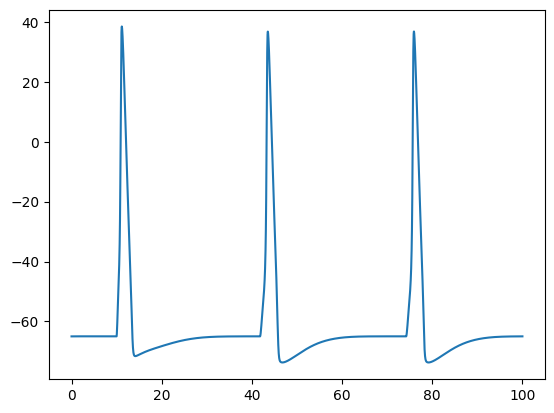

In [9]:
import matplotlib.pyplot as plt

plt.plot(t, list(ring.cells[0].soma_v))
plt.show()

Cell 0 looks good. Let's look at the raster diagram:

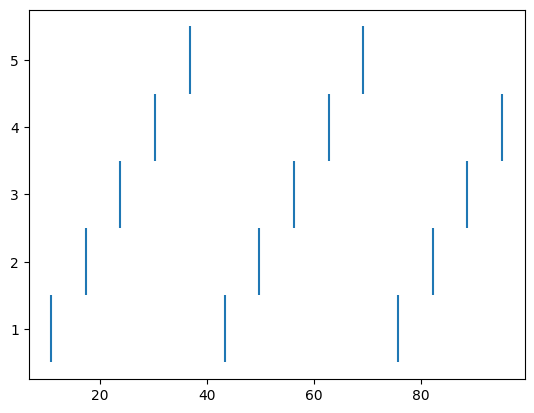

In [10]:
plt.figure()
for i, cell in enumerate(ring.cells):
    plt.vlines(list(cell.spike_times), i + 0.5, i + 1.5)
plt.show()

## Explore effects of parameters

Let's compare two simulations: one with the same parameters as above, which we'll plot in black, and one with half the synaptic weight, which we'll plot in red:

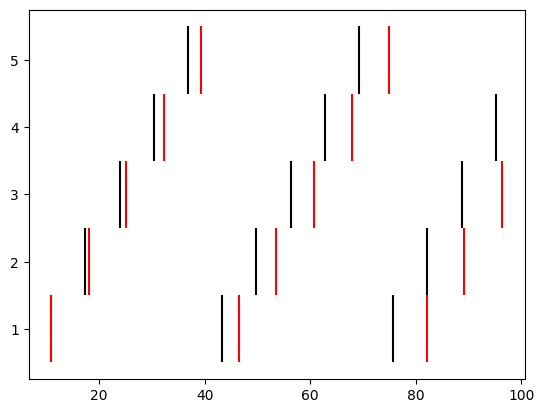

In [11]:
plt.figure()
for syn_w, color in [(0.01, "black"), (0.005, "red")]:
    ring = Ring(N=5, syn_w=syn_w)
    h.finitialize(-65 * mV)
    h.continuerun(100 * ms)
    for i, cell in enumerate(ring.cells):
        plt.vlines(list(cell.spike_times), i + 0.5, i + 1.5, color=color)

plt.show()

In both simulations, the first spike occurs at 10.925 ms. After that, the red spikes lag the black ones by steadily increasing amounts.

The next part of the tutorial will translate this serial model into a parallel model. That part will not work in Jupyter and must be run from a terminal.